In [ ]:
from functools import partial
import torch
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary
import torch.nn as nn

## Backgrounds

In [ ]:
tensor_3_4 = torch.arange(12).reshape(3,4).float()
tensor_3_4 = tensor_3_4.unsqueeze(0)
print(tensor_3_4.shape) # (1, 3, 4) # token: 3, dim: 4
print(tensor_3_4)
print('='*50)

# transpose eniops
tensor_4_3 = Rearrange('b n d -> b d n')(tensor_3_4) # transpose
print(tensor_4_3) # (1,4,3)
print('='*50)

# token feature avarage
print(tensor_4_3.mean(dim=1)) # token features average (!=token avg, GAP)
tensor_4_3.mean(dim=1).shape

In [ ]:
# transpose by eniops
input = torch.arange(0,12).reshape(3,4)
print(input)
print("="*50)
output = Rearrange('n d -> d n')(input)
print(output)


In [ ]:
# token LayerNorm
test = torch.arange(0,12).reshape(1,3,4).float()
layer_norm = nn.LayerNorm(4) # input is dim of tokens
print(test)
print('='*50)
print(layer_norm(test))

# NLP Example
batch, sentence_length, embedding_dim = 20, 5, 10
embedding = torch.randn(batch, sentence_length, embedding_dim)
layer_norm = nn.LayerNorm(embedding_dim)
# Activate module
layer_norm(embedding)

# Image Example
N, C, H, W = 20, 5, 10, 10
input = torch.randn(N, C, H, W)
# Normalize over the last three dimensions (i.e. the channel and spatial dimensions)
# as shown in the image below
layer_norm = nn.LayerNorm([C, H, W])
output = layer_norm(input)

## model architecture

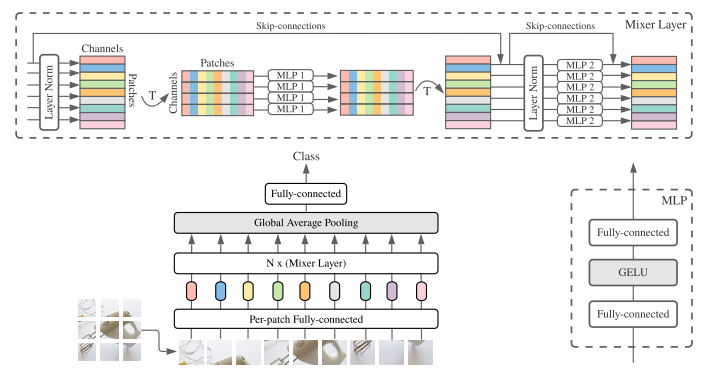

### reference code  
* https://github.com/rishikksh20/MLP-Mixer-pytorch

In [ ]:
# mlp_block
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim), # expansion
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self,x):
        return self.net(x)

# mixer_block
class MixerBlock(nn.Module):
    def __init__(self, 
                 dim, # n_dim == features
                 num_patches,
                 token_dim,
                 channel_dim, 
                 dropout=0.):
        super().__init__()
        # between token, spatial feature
        self.token_mix = nn.Sequential(
            nn.LayerNorm(dim),
            Rearrange('b n d -> b d n'),
            FeedForward(num_patches, token_dim, dropout), # token_dim -> hidden_dim
            Rearrange('b d n -> b n d')
        )

        # in token, channel feature
        self.channel_mix = nn.Sequential(
            nn.LayerNorm(dim),
            FeedForward(dim, channel_dim, dropout), # channel_dim -> hidden_dim
        )
    def forward(self, x):
        x = x + self.token_mix(x)
        x = x + self.channel_mix(x)
        return x

# model_block
class MLPMixer(nn.Module):
    def __init__(self, 
                 in_channels, 
                 dim, 
                 num_classes, 
                 patch_size, 
                 image_size,
                 depth, 
                 token_dim, 
                 channel_dim):
        super().__init__()
        assert image_size%patch_size == 0, 'Image dimensions must be divisible by the patch_size'
        self.num_patch = (image_size//patch_size) ** 2
        self.to_patch_embedding = nn.Sequential(
            nn.Conv2d(in_channels, 
                      dim, 
                      kernel_size=patch_size, 
                      stride=patch_size), # output feature map
            Rearrange('b c h w -> b (h w) c'),
        )

        self.mixer_blocks = nn.ModuleList([])

        for _ in range(depth):
            self.mixer_blocks.append(
                MixerBlock(dim, 
                           self.num_patch, 
                           token_dim, 
                           channel_dim)
                           )
        
        self.layer_norm = nn.LayerNorm(dim)

        self.mlp_head = nn.Sequential(
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        x = self.to_patch_embedding(x)
        for mixer_block in self.mixer_blocks:
            x = mixer_block(x)
        x = self.layer_norm(x) # before GAP norm
        x = x.mean(dim=1)
        x = self.mlp_head(x)
        return x

In [ ]:
mlp_mixer=MLPMixer(in_channels=3, 
                   dim=512, 
                   num_classes=1000, 
                   patch_size=16, 
                   image_size=224, 
                   depth=1, 
                   token_dim=196, # expansion dim
                   channel_dim=512)

summary(mlp_mixer, (3,224,224), device='cpu')

## scratch code
* MLP_Mixer 
    * PatchEmbedBlock
    * MixerBlock  
        * token_mix
        * channel_mix
        * GAP
    * Classifier

![image.png](../figure/mlp_mixer.PNG)

In [ ]:
class PatchEmbedBlock(nn.Module):
    def __init__(self, 
                 img_size, 
                 patch_size, 
                 feature_dim):
        super().__init__()
        assert img_size%patch_size==0, 'img_size%patch_size != 0'
        self.img_size = img_size
        self.n_patches = (img_size%patch_size)**2
        self.embed_layer = nn.Conv2d(3, 
                                     feature_dim, 
                                     kernel_size=patch_size, 
                                     stride=patch_size)
        self.flatten_layer = Rearrange('b c h w -> b (h w) c')

    def forward(self, x):
        assert x.shape[2] == self.img_size, 'input height != img_size'
        assert x.shape[3] == self.img_size, 'input width != img_size'
        x = self.embed_layer(x)
        x = self.flatten_layer(x)
        return x
    
class DenseBlock(nn.Module):
    def __init__(self, dim, expansion_ratio, dropout=0.):
        super().__init__()
        self.dim = dim
        self.hidden_dim = int(expansion_ratio*dim)
        self.net = nn.Sequential(
            nn.Linear(self.dim, self.hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(self.hidden_dim, self.dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = self.net(x)
        return x

class MixerBlock(nn.Module):
    def __init__(self, 
                 img_size, 
                 patch_size, 
                 feature_dim,
                 expansion_ratio):
        super().__init__()

        self.n_patches = (img_size//patch_size)**2
        self.feature_dim = feature_dim
        
        self.layer_norm = nn.LayerNorm(feature_dim)
        self.transpose_layer = Rearrange('b p c -> b c p')
        self.token_mix_layer = DenseBlock(dim=self.n_patches, 
                                          expansion_ratio=expansion_ratio)
        self.channel_mix_layer = DenseBlock(dim=feature_dim, 
                                            expansion_ratio=expansion_ratio)
        
    
    def forward(self, x):
        x1 = self.layer_norm(x)
        x1 = self.transpose_layer(x1)
        x1 = self.token_mix_layer(x1)
        x1 = self.transpose_layer(x1)
        x = x + x1
        x2 = self.layer_norm(x)
        x2 = self.channel_mix_layer(x2)
        x = x + x2
        return x


class GlobalAvgPool1d(nn.Module):
    def forward(self, x):
        # Compute global average pooling along the tokens dimension
        x_pool = torch.mean(x, dim=1)
        return x_pool


class MLP_Mixer(nn.Module):
    def __init__(self,
                 img_size,
                 patch_size,
                 feature_dim,
                 expansion_ratio,
                 depth,
                 n_classes
                 ):
        super().__init__()
        self.n_patches = (img_size//patch_size)**2
        self.embed_block = PatchEmbedBlock(img_size, 
                                           patch_size, 
                                           feature_dim)
        self.mixer_blocks = nn.Sequential(
            *[MixerBlock(img_size, 
                         patch_size, 
                         feature_dim, 
                         expansion_ratio) for i in range(depth)],
            nn.LayerNorm(feature_dim),
            GlobalAvgPool1d()
        )
        self.classifier = nn.Linear(feature_dim, 
                                    n_classes)


    def forward(self, x):
        x = self.embed_block(x) # b p d
        x = self.mixer_blocks(x)
        x = self.classifier(x)
        return x


mixer = MLP_Mixer(img_size = 224, 
                  patch_size = 16, 
                  feature_dim = 512, 
                  expansion_ratio = 1, 
                  depth = 1,
                  n_classes = 1000
                  )

In [ ]:
summary(mixer,(3,224,224), device='cpu')